In [ ]:
# default_exp image_blending

# Image Blending

# Task 5: Image blending in gradient area

Implementujte techniku bezešvého skládání obrazů v gradientní oblasti. Pro výpočet výsledného lineárního systému použijte iterativní metodu Gauss-Seidel. Demonstrujte funkčnost výsledné implementace na příkladě složení dvou snímků se znatelně odlišnou úrovní expozice.

In [ ]:
# export
import numpy as np

In [ ]:
from tqdm import trange
import matplotlib.pyplot as plt
from dzotools.utils import imgload, arr2img
from IPython.display import clear_output

background = imgload('data/blending/windows_normal.png')
foreground = imgload('data/blending/windows_dark.png')

# Load the mask and binarize it to 0, 1 and invert
mask = imgload('data/blending/windows_mask.png', convert="L")
mask = 1 - np.round(mask / 256.0).astype(float)

### Edge Padded Array
Neglect the borders by returning 0 if out of bounds. Wraps around a numpy array.

In [ ]:
# exports
class WrappedNdArray:
    """Wraps an ndarray and only returns value if within bounds."""
    def __init__(self, array: np.ndarray):
        self.array = array
        
    def is_inside(self, location):
        return all([
            0 <= location[0] < self.array.shape[0],
            0 <= location[1] < self.array.shape[1],
        ])
        
    def __getitem__(self, location):
        if self.is_inside(location):
            return self.array[location]
        return 0
        
    def __setitem__(self, location, value):
        if self.is_inside(location):
            self.array[location] = value

In [ ]:
wrapped = WrappedNdArray(
    np.array([[1, 2, 3], [4, 5, 6]])
)

assert wrapped[10, 0] == 0
assert wrapped[0, 0] == 1
assert wrapped[0, 1] == 2

### Utility functions
Implement laplace operator which computes the discrete laplace operator at given location coordinates.

$$
b[y, x] = -4 * s[y, x] + s[y+1, x] + s[y-1, x] + s[y, x+1] + s[y, x-1]
$$

In [ ]:
# exports
def laplace_op(y: int, x: int, arr: np.array) -> float:
    """Calculate the discrete Laplace operator on arr"""
    return -4 * arr[y, x] + arr[y+1, x] + arr[y-1, x] + arr[y, x+1] + arr[y, x-1]

In [ ]:
arr = np.array([
    [1, 1, 1, 1, 1],
    [1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1],
])

assert laplace_op(1, 1, arr) == 0
assert laplace_op(1, 2, arr) == -1
assert laplace_op(1, 3, arr) == 4

### Prepare the data
Mask is $0$ if background should be kept. If mask is $1$, then we should be using the foreground and blend it with background.

In [ ]:
def prepare_target(mask, foreground, background):
    """Calculate the vector b used for Gauss-Seidel computation."""
    b = np.zeros_like(background, dtype="float32")
    
    _fg = WrappedNdArray(foreground)
    _bg = WrappedNdArray(background)

    heigth, width = mask.shape
    for y in range(heigth):
        for x in range(width):
            selected_layer = _fg if mask[y, x] == 1 else _bg
            b[y, x] = laplace_op(y, x, selected_layer)
            
    return b

### Gauss-Seidel Iteration
Start with the image composed of the applied hard mask. Only update the masked indexes and keep refining the gradients.

In [ ]:
masked = np.where(mask[...,None], foreground, background)

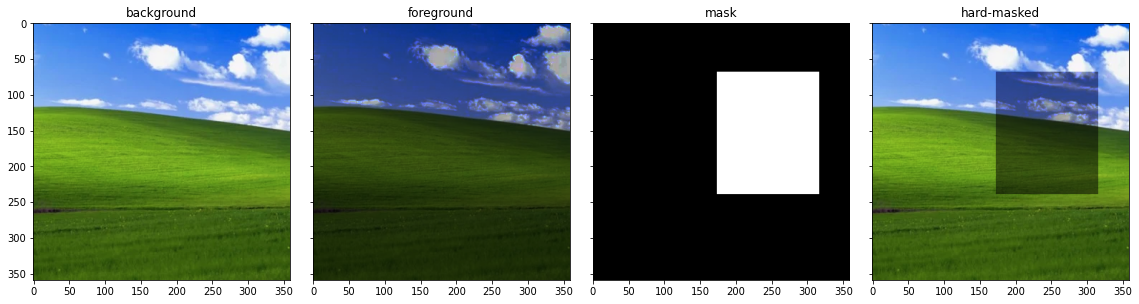

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(16, 4), sharey=True)
ax[0].imshow(background, vmin=0, vmax=255)
ax[0].set_title("background")
ax[1].imshow(foreground, vmin=0, vmax=255)
ax[1].set_title("foreground")
ax[2].imshow(mask, vmin=0, vmax=1, cmap='gray')
ax[2].set_title("mask")
ax[3].imshow(masked, vmin=0, vmax=255)
ax[3].set_title("hard-masked")
plt.tight_layout()
plt.show()